# ClimateNet AR Analysis: ERA data

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl
import datetime
import pandas as pd

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '20GiB' # PBSCluster specification
nmem2 = '20GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(25) # 25 (at least) for processing 3hrly data
#cluster.scale(10)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

<Client: 'tcp://128.117.208.99:40423' processes=0 threads=0, memory=0 B>

## ERA5 Hourly Data

In [4]:
era_data_path = "/glade/campaign/collections/rda/data/d651018/ERA5/"

In [5]:
# IWV
era_iwv_files = "ERA5_IWV_20*.nc" # each file is a month worth of hourly data, this pulls 2000-2019

# U/V850
era_uv_files = "ERA5_850hpawinds_20*.nc" # each file is a month worth of hourly data, this pulls 2000-2019

### Read in data

In [8]:
%%time
era_iwv_dataset = xr.open_mfdataset(era_data_path+era_iwv_files, concat_dim='time', combine='nested', parallel=True, chunks='auto')
era_iwv_dataset

CPU times: user 5.62 s, sys: 305 ms, total: 5.92 s
Wall time: 32.8 s


<xarray.Dataset> Size: 1TB
Dimensions:    (time: 175320, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1MB 2000-01-01 ... 2019-12-31T23:00:00
Data variables:
    tcwv       (time, latitude, longitude) float64 1TB dask.array<chunksize=(207, 201, 401), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-07-14 11:18:22 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [6]:
%%time
#era_uv_dataset = xr.open_mfdataset(era_data_path+era_uv_files, concat_dim='time', combine='nested', parallel=True, chunks='auto')
# try only chunking in space because all the operations are across the time dim? For some reason it is ignoring the time chunks here, not sure why
era_uv_dataset = xr.open_mfdataset(era_data_path+era_uv_files, concat_dim='time', combine='nested', parallel=True, chunks={'time':1000, 'longitude':700, 'latitude':700})
era_uv_dataset

CPU times: user 2.76 s, sys: 177 ms, total: 2.94 s
Wall time: 19.3 s


<xarray.Dataset> Size: 3TB
Dimensions:    (time: 175320, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1MB 2000-01-01 ... 2019-12-31T23:00:00
Data variables:
    u          (time, latitude, longitude) float64 1TB dask.array<chunksize=(744, 700, 700), meta=np.ndarray>
    v          (time, latitude, longitude) float64 1TB dask.array<chunksize=(744, 700, 700), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-19 11:53:39 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

### Subset years

In [10]:
era_iwv = era_iwv_dataset['tcwv'].sel(time=slice('2000-01-01', '2014-12-31'))
era_iwv

<xarray.DataArray 'tcwv' (time: 131496, latitude: 721, longitude: 1440)> Size: 1TB
dask.array<getitem, shape=(131496, 721, 1440), dtype=float64, chunksize=(207, 201, 401), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1MB 2000-01-01 ... 2014-12-31T23:00:00
Attributes:
    units:          kg m**-2
    long_name:      Total column water vapour
    standard_name:  lwe_thickness_of_atmosphere_mass_content_of_water_vapor

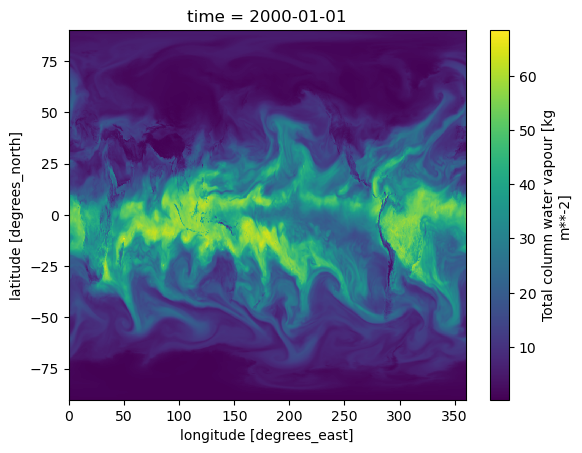

In [12]:
era_iwv.isel(time=0).plot();

In [8]:
era_uv850 = era_uv_dataset.sel(time=slice('2000-01-01', '2014-12-31'))
era_uv850

<xarray.Dataset> Size: 2TB
Dimensions:    (time: 131496, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1MB 2000-01-01 ... 2014-12-31T23:00:00
Data variables:
    u          (time, latitude, longitude) float64 1TB dask.array<chunksize=(744, 700, 700), meta=np.ndarray>
    v          (time, latitude, longitude) float64 1TB dask.array<chunksize=(744, 700, 700), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-19 11:53:39 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

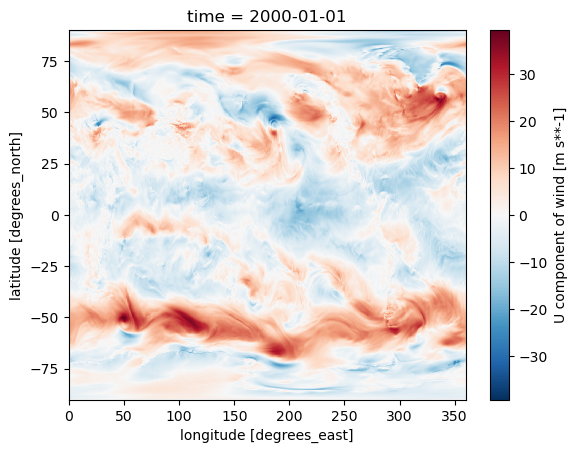

In [13]:
era_uv850['u'].isel(time=0).plot();

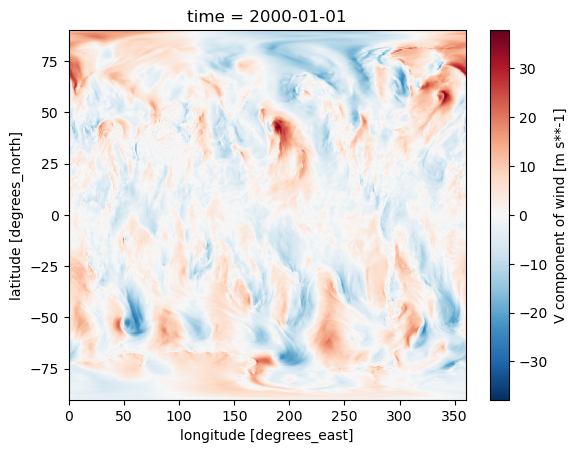

In [14]:
era_uv850['v'].isel(time=0).plot();

### Resample monthly means

In [15]:
era_iwv_month = era_iwv.resample(time="M").mean()
era_iwv_month

<string>:7: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


<xarray.DataArray 'tcwv' (time: 180, latitude: 721, longitude: 1440)> Size: 1GB
dask.array<stack, shape=(180, 721, 1440), dtype=float64, chunksize=(1, 201, 401), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1kB 2000-01-31 2000-02-29 ... 2014-12-31
Attributes:
    units:          kg m**-2
    long_name:      Total column water vapour
    standard_name:  lwe_thickness_of_atmosphere_mass_content_of_water_vapor

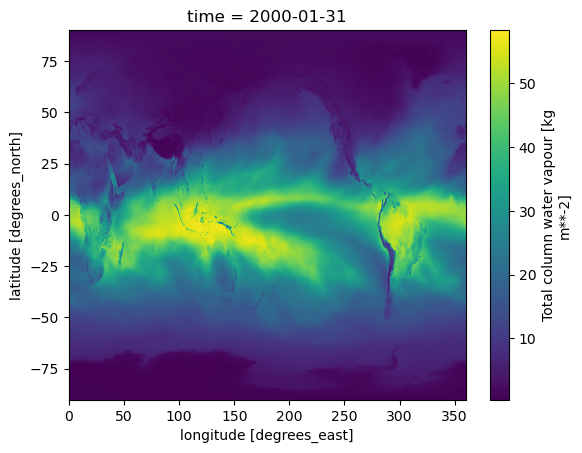

In [16]:
era_iwv_month.isel(time=0).plot();

In [30]:
lat_bounds_era = slice(65,25) # ERA reversed lats...
lon_bounds_era = slice(180,255)

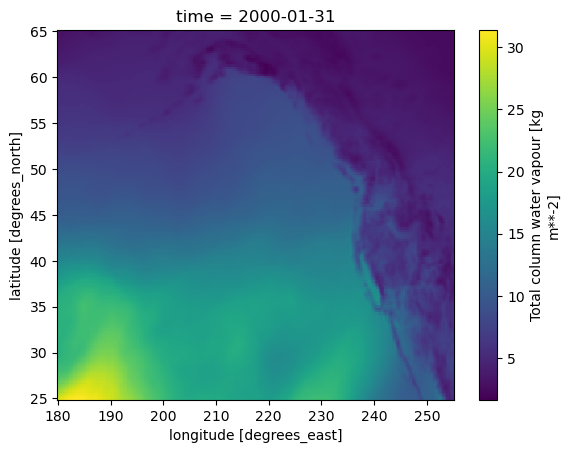

In [31]:
era_iwv_month.isel(time=0).sel(latitude=lat_bounds_era, longitude=lon_bounds_era).plot();

In [9]:
era_uv_month = era_uv850.resample(time="M").mean()
era_uv_month

<string>:7: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


<xarray.Dataset> Size: 3GB
Dimensions:    (time: 180, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1kB 2000-01-31 2000-02-29 ... 2014-12-31
Data variables:
    u          (time, latitude, longitude) float64 1GB dask.array<chunksize=(1, 700, 700), meta=np.ndarray>
    v          (time, latitude, longitude) float64 1GB dask.array<chunksize=(1, 700, 700), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-19 11:53:39 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

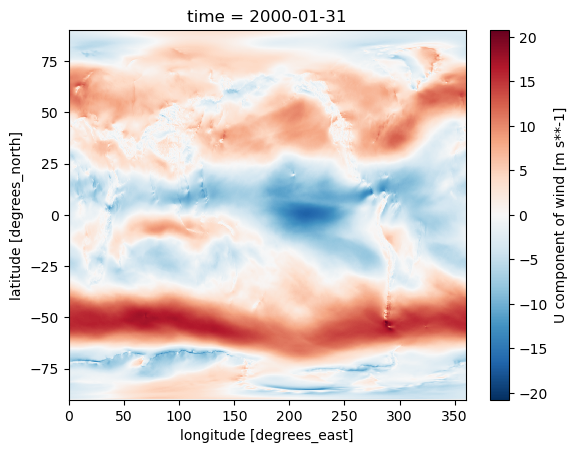

In [18]:
era_uv_month['u'].isel(time=0).plot()

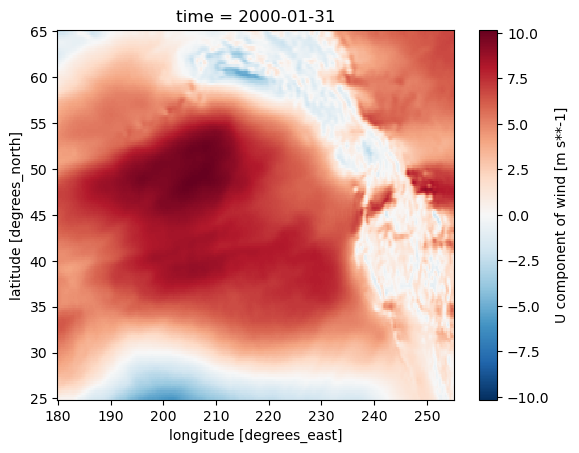

In [32]:
era_uv_month['u'].isel(time=0).sel(latitude=lat_bounds_era, longitude=lon_bounds_era).plot();

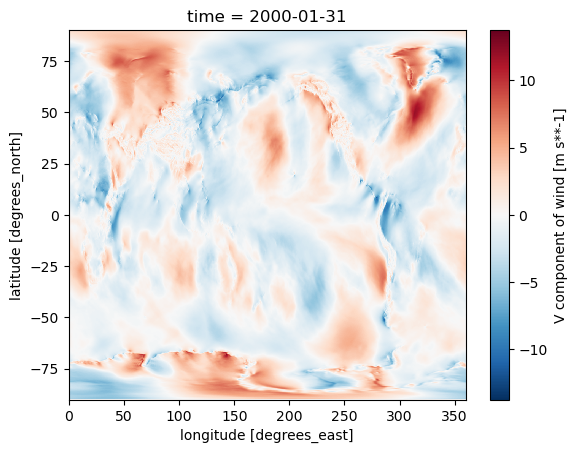

In [19]:
era_uv_month['v'].isel(time=0).plot();

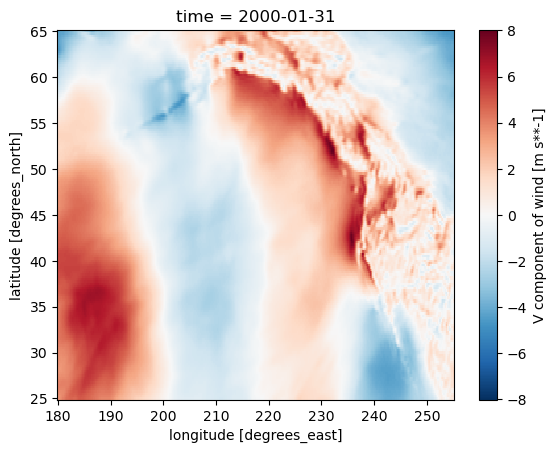

In [33]:
era_uv_month['v'].isel(time=0).sel(latitude=lat_bounds_era, longitude=lon_bounds_era).plot();

### Test groupby operations

In [35]:
era_iwv_month.groupby('time.season').mean()

<xarray.DataArray 'tcwv' (season: 4, latitude: 721, longitude: 1440)> Size: 33MB
dask.array<stack, shape=(4, 721, 1440), dtype=float64, chunksize=(1, 201, 401), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * season     (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    units:          kg m**-2
    long_name:      Total column water vapour
    standard_name:  lwe_thickness_of_atmosphere_mass_content_of_water_vapor

In [20]:
era_uv_month['u'].groupby('time.season').mean()

<xarray.DataArray 'u' (season: 4, latitude: 721, longitude: 1440)> Size: 33MB
dask.array<stack, shape=(4, 721, 1440), dtype=float64, chunksize=(1, 700, 700), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * season     (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    units:          m s**-1
    long_name:      U component of wind
    standard_name:  eastward_wind

In [21]:
era_uv_month['v'].groupby('time.season').mean()

<xarray.DataArray 'v' (season: 4, latitude: 721, longitude: 1440)> Size: 33MB
dask.array<stack, shape=(4, 721, 1440), dtype=float64, chunksize=(1, 700, 700), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * season     (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    units:          m s**-1
    long_name:      V component of wind
    standard_name:  northward_wind

### Save out monthly data

12/19/25: With auto chunks and no persisting, took 41min to save IWV

In [38]:
%%time
era_iwv_month.to_netcdf("/glade/campaign/cgd/ccr/kdagon/cgnet/ERA5/ERA5_IWV_monthly_2000-2014.nc")

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 30.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 9min 43s, sys: 25.1 s, total: 10min 8s
Wall time: 41min 18s


For U/V, maybe persist first? Or different chunking / fewer chunks?\
12/19/25: Ran out of time to save out U/V file...trying different chunking next time\
12/22/25: I did not time this but it took about 5 min to persist with 20GB x 25 workers and 2.7GB chunksize at read in

In [10]:
era_uv_month = era_uv_month.persist()

12/22/25: 4 min to save after persisting!

In [11]:
%%time
era_uv_month.to_netcdf("/glade/campaign/cgd/ccr/kdagon/cgnet/ERA5/ERA5_UV850_monthly_2000-2014.nc")

CPU times: user 39 s, sys: 2.35 s, total: 41.3 s
Wall time: 4min 34s


## ERA5 Monthly Data

In [4]:
era_iwv_month_new = xr.open_dataarray("/glade/campaign/cgd/ccr/kdagon/cgnet/ERA5/ERA5_IWV_monthly_2000-2014.nc", chunks={'time':50})
era_iwv_month_new

<xarray.DataArray 'tcwv' (time: 180, latitude: 721, longitude: 1440)> Size: 1GB
dask.array<open_dataset-tcwv, shape=(180, 721, 1440), dtype=float64, chunksize=(50, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1kB 2000-01-31 2000-02-29 ... 2014-12-31
Attributes:
    units:          kg m**-2
    long_name:      Total column water vapour
    standard_name:  lwe_thickness_of_atmosphere_mass_content_of_water_vapor

In [5]:
era_iwv_month_new = era_iwv_month_new.persist()

In [6]:
era_uv_month_new = xr.open_dataset("/glade/campaign/cgd/ccr/kdagon/cgnet/ERA5/ERA5_UV850_monthly_2000-2014.nc", chunks={'time':50})
era_uv_month_new

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 180, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1kB 2000-01-31 2000-02-29 ... 2014-12-31
Data variables:
    u          (time, latitude, longitude) float64 1GB dask.array<chunksize=(50, 721, 1440), meta=np.ndarray>
    v          (time, latitude, longitude) float64 1GB dask.array<chunksize=(50, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-19 11:53:39 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [7]:
era_uv_month_new = era_uv_month_new.persist()

### Annual Means

In [8]:
era_iwv_annual = era_iwv_month_new.mean(dim='time')

In [9]:
era_uv_annual = era_uv_month_new.mean(dim='time')
#era_uv_annual

### Seasonal means

In [10]:
era_iwv_season = era_iwv_month_new.groupby('time.season').mean()

In [11]:
era_uv_season = era_uv_month_new.groupby('time.season').mean()

## CESM Monthly Data

### TMQ

In [60]:
TMQ_cesm_month_full = xr.open_dataarray("/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/CESM_hist_TMQ_monthly_2000-2015.nc", chunks={'time':50})
TMQ_cesm_month = TMQ_cesm_month_full.sel(time=slice("2000","2014"))

In [61]:
TMQ_cesm_month = TMQ_cesm_month.persist()

### U/V850

In [62]:
UV850_cesm_month_full = xr.open_dataset("/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/CESM_hist_UV850_monthly_2000-2015.nc", chunks={'time':50})
UV850_cesm_month = UV850_cesm_month_full.sel(time=slice("2000","2014"))

In [63]:
UV850_cesm_month = UV850_cesm_month.persist()

### Annual Means

In [64]:
TMQ_cesm_mean = TMQ_cesm_month.mean(dim='time')

In [65]:
UV850_cesm_mean = UV850_cesm_month.mean(dim='time')

### Seasonal Means

In [66]:
TMQ_cesm_season_climo = TMQ_cesm_month.groupby('time.season').mean()

In [67]:
UV850_cesm_season_climo = UV850_cesm_month.groupby('time.season').mean()

## Comparing ERA / CESM
Remap CESM to ERA grid to calculate differences

### TMQ

In [68]:
%%time
regridder = xe.Regridder(TMQ_cesm_month, era_iwv_month_new, "bilinear", periodic=True)
regridder

CPU times: user 29.2 s, sys: 1.25 s, total: 30.5 s
Wall time: 27.3 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_768x1152_721x1440_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (768, 1152) 
Output grid shape:          (721, 1440) 
Periodic in longitude?      True

In [69]:
%%time
TMQ_cesm_month_eragrid = regridder(TMQ_cesm_month, keep_attrs=True)
TMQ_cesm_month_eragrid

CPU times: user 327 ms, sys: 11 ms, total: 338 ms
Wall time: 300 ms


<xarray.DataArray 'TMQ' (time: 180, latitude: 721, longitude: 1440)> Size: 748MB
dask.array<astype, shape=(180, 721, 1440), dtype=float32, chunksize=(50, 721, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1kB 2000-01-31 00:00:00 ... 2014-12-31 00:00:00
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    conventions:    CF 1.0
    creator:        Teagan King, tking@ucar.edu
    creation_date:  2023-02-17
    summary:        Create input for ClimateNet application
    contact:        Teagan King, tking@ucar.edu
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    units:          kg/m2
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    regrid_method:  bilinear

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 95.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


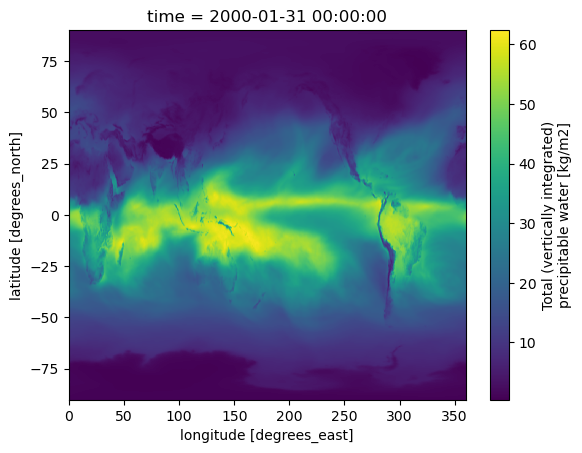

In [25]:
TMQ_cesm_month_eragrid.isel(time=0).plot()

In [70]:
TMQ_cesm_month_eragrid = TMQ_cesm_month_eragrid.persist()

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 95.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [71]:
TMQ_cesm_month_eragrid_mean = TMQ_cesm_month_eragrid.mean(dim='time')

In [72]:
TMQ_cesm_season_climo_eragrid = TMQ_cesm_month_eragrid.groupby('time.season').mean()

### U/V850
Use the same regridder as TMQ to save memory

In [73]:
%%time
UV850_cesm_month_eragrid = regridder(UV850_cesm_month, keep_attrs=True)
UV850_cesm_month_eragrid

CPU times: user 744 ms, sys: 60.4 ms, total: 804 ms
Wall time: 680 ms


<xarray.Dataset> Size: 1GB
Dimensions:    (time: 180, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) object 1kB 2000-01-31 00:00:00 ... 2014-12-31 00:00:00
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    U850       (time, latitude, longitude) float32 748MB dask.array<chunksize=(50, 721, 1152), meta=np.ndarray>
    V850       (time, latitude, longitude) float32 748MB dask.array<chunksize=(50, 721, 1152), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [74]:
UV850_cesm_month_eragrid = UV850_cesm_month_eragrid.persist()

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 95.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


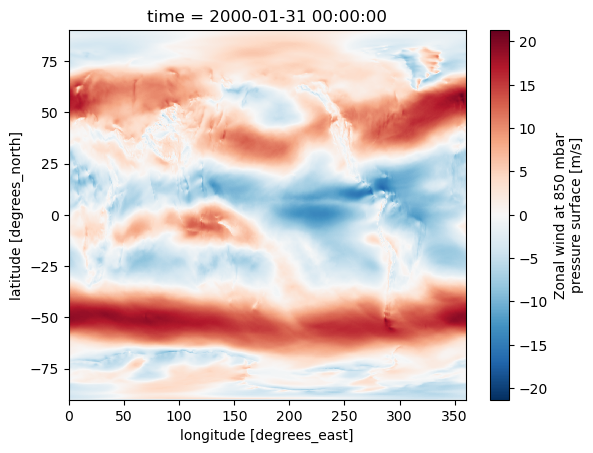

In [33]:
UV850_cesm_month_eragrid['U850'].isel(time=0).plot()

In [75]:
UV850_cesm_month_eragrid_mean = UV850_cesm_month_eragrid.mean(dim='time')

In [76]:
UV850_cesm_season_climo_eragrid = UV850_cesm_month_eragrid.groupby('time.season').mean()

### Annual Differences

In [77]:
era_cesm_iwv_diff = era_iwv_annual - TMQ_cesm_month_eragrid_mean

In [78]:
print('TMQ/IWV diffs are ', era_cesm_iwv_diff.min().values, era_cesm_iwv_diff.max().values)

TMQ/IWV diffs are  -12.823449501543944 15.165423664906584


Should do the U/V diffs by variable

In [79]:
era_cesm_u_diff = era_uv_annual['u'] - UV850_cesm_month_eragrid_mean['U850']

In [80]:
era_cesm_v_diff = era_uv_annual['v'] - UV850_cesm_month_eragrid_mean['V850']

In [81]:
print('U850 diffs are ', era_cesm_u_diff.min().values, era_cesm_u_diff.max().values)
print('V850 diffs are ', era_cesm_v_diff.min().values, era_cesm_v_diff.max().values)

U850 diffs are  -11.016880546966156 5.838694908043656
V850 diffs are  -8.536806419339019 9.361261602964923


### Annual Panel plots

/glade/derecho/scratch/kdagon/tmp/ipykernel_41781/732052855.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('seismic')


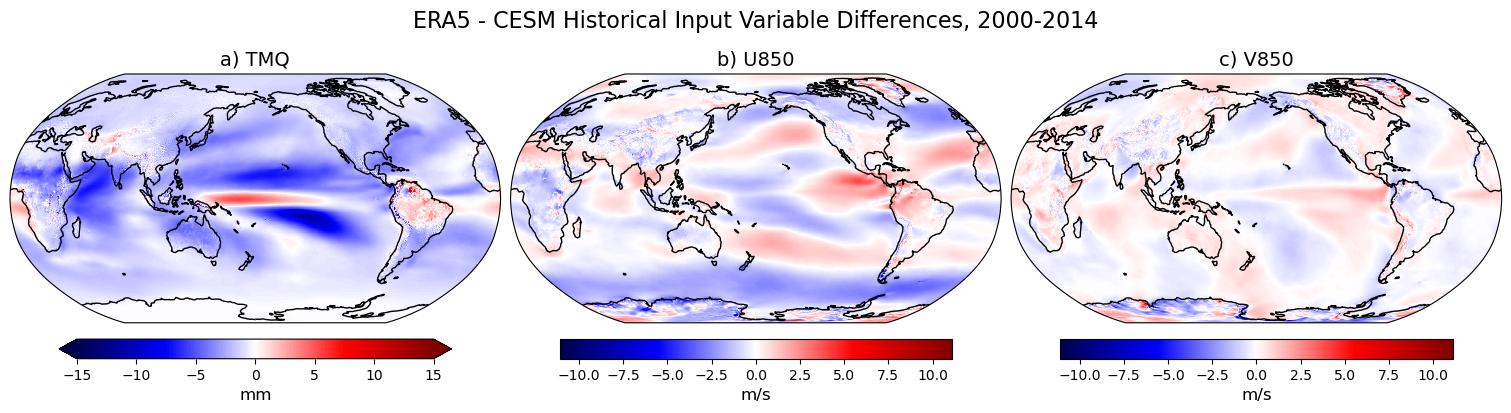

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)}, constrained_layout=True)  # 1 row, 3 columns

# define coordinates throughout
lat = era_cesm_iwv_diff.latitude
lon = era_cesm_iwv_diff.longitude

# IWV/TMQ cmap
cmap=plt.cm.get_cmap('seismic')
vmin=-15
vmax=15

# TMQ/IWV diff
pc = axes[0].pcolormesh(lon, lat, era_cesm_iwv_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].set_title('a) TMQ', fontsize=14)

# winds cmap
vmin_w=-11.1
vmax_w=11.1

# U850 diff
pc_u = axes[1].pcolormesh(lon, lat, era_cesm_u_diff, cmap=cmap, vmin=vmin_w, vmax=vmax_w, transform=ccrs.PlateCarree())
axes[1].coastlines()
axes[1].set_title('b) U850', fontsize=14)

# V850 diff
pc_v = axes[2].pcolormesh(lon, lat, era_cesm_v_diff, cmap=cmap, vmin=vmin_w, vmax=vmax_w, transform=ccrs.PlateCarree())
axes[2].coastlines()
axes[2].set_title('c) V850', fontsize=14)

# add TMQ colorbar
#cbar_ax = fig.add_axes([0.2, 0.15, 0.2, 0.03]) #(left, bottom, width, height)
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar = fig.colorbar(pc, ax=axes[0], location='bottom', shrink=0.8, extend='both')
cbar.ax.set_xlabel('mm', fontsize=12)

# add U850 colorbar
#cbar_ax = fig.add_axes([0.5, 0.15, 0.2, 0.03]) #(left, bottom, width, height)
#cbar = plt.colorbar(pc_u, cax=cbar_ax, orientation='horizontal')
cbar = fig.colorbar(pc_u, ax=axes[1], location='bottom', shrink=0.8)
cbar.ax.set_xlabel('m/s', fontsize=12)

# add V850 colorbar
#cbar_ax = fig.add_axes([0.5, 0.15, 0.2, 0.03]) #(left, bottom, width, height)
#cbar = plt.colorbar(pc_u, cax=cbar_ax, orientation='horizontal')
cbar = fig.colorbar(pc_v, ax=axes[2], location='bottom', shrink=0.8)
cbar.ax.set_xlabel('m/s', fontsize=12)

# add suptitle
fig.suptitle('ERA5 - CESM Historical Input Variable Differences, 2000-2014', fontsize=16)

#plt.subplots_adjust(wspace=0.1, hspace=0.3)
#plt.tight_layout() # does not work with constrained_layout=True

#plt.savefig('../figures/toSCP/ERA-CESM-TMQ_UV850_diffs_2000-2014.png', bbox_inches='tight')

### Seasonal differences

In [82]:
lat_bounds_era = slice(65,25)
lon_bounds_era = slice(180,255)

In [83]:
era_cesm_iwv_diff_season = era_iwv_season - TMQ_cesm_season_climo_eragrid

In [84]:
print('TMQ/IWV diffs are ', era_cesm_iwv_diff_season.sel(latitude=lat_bounds_era,longitude=lon_bounds_era).min().values, era_cesm_iwv_diff_season.sel(latitude=lat_bounds_era,longitude=lon_bounds_era).max().values)

TMQ/IWV diffs are  -6.527306284962474 3.3518067106387583


Should do the U/V diffs by variable

In [85]:
era_cesm_u_diff_season = era_uv_season['u'] - UV850_cesm_season_climo_eragrid['U850']

In [86]:
era_cesm_v_diff_season = era_uv_season['v'] - UV850_cesm_season_climo_eragrid['V850']

In [88]:
print('U850 diffs are ', era_cesm_u_diff_season.sel(latitude=lat_bounds_era,longitude=lon_bounds_era).min().values, 
      era_cesm_u_diff_season.sel(latitude=lat_bounds_era,longitude=lon_bounds_era).max().values)
print('V850 diffs are ', era_cesm_v_diff_season.sel(latitude=lat_bounds_era,longitude=lon_bounds_era).min().values, 
      era_cesm_v_diff_season.sel(latitude=lat_bounds_era,longitude=lon_bounds_era).max().values)

U850 diffs are  -4.298303101124097 3.9714058478724854
V850 diffs are  -5.0808720400331655 3.4565630225963773


CPU times: user 4.36 s, sys: 254 ms, total: 4.61 s
Wall time: 7.3 s


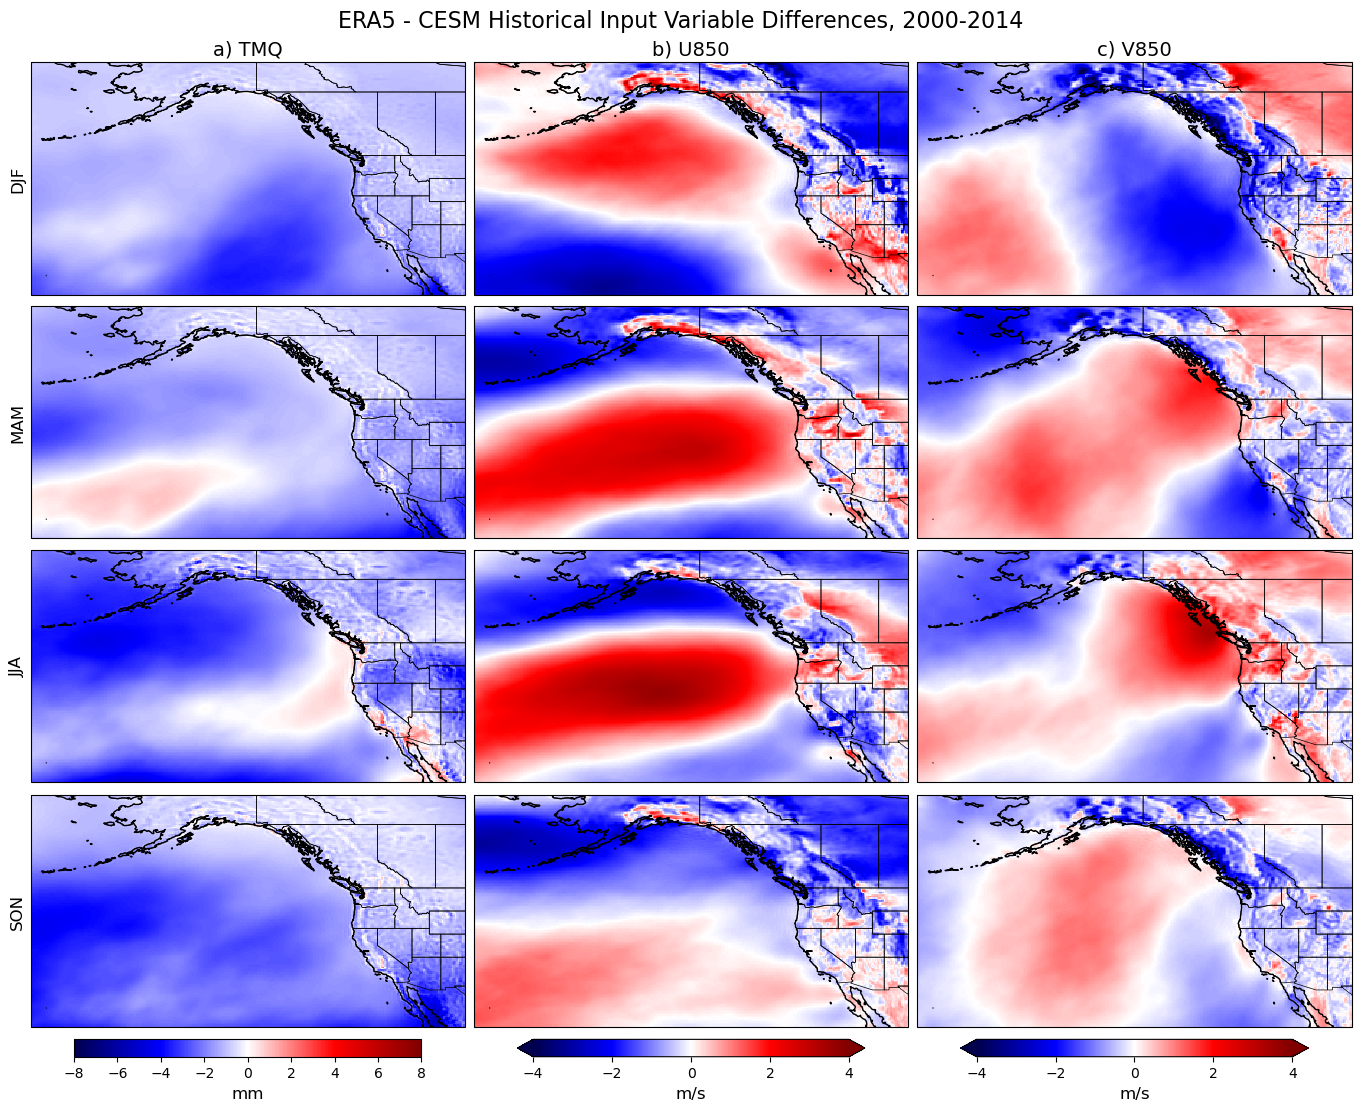

[WARNING] yaksa: 10 leaked handle pool objects


In [90]:
%%time
fig, ax = plt.subplots(4, 3, figsize=(13.5,11), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}, constrained_layout=True) # figsize is width, height

cmap = mpl.colormaps.get_cmap('seismic')

# regional subset
lat_bounds_era = slice(65,25)
lon_bounds_era = slice(180,255)

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    #print(i)
    # TMQ/IWV
    lat = era_cesm_iwv_diff_season.latitude.sel(latitude=lat_bounds_era)
    lon = era_cesm_iwv_diff_season.longitude.sel(longitude=lon_bounds_era)
    pc1 = ax[i,0].pcolormesh(lon, lat, era_cesm_iwv_diff_season.sel(season=season, latitude=lat_bounds_era, longitude=lon_bounds_era), cmap=cmap, vmin=-8, vmax=8, transform=ccrs.PlateCarree())
    ax[i,0].coastlines(zorder=1)
    ax[i,0].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    ax[i,0].set_ylabel(season, fontsize=12)
    ax[i,0].set_yticks([])
    if i==0:
        ax[i,0].set_title('a) TMQ', fontsize=14)

    # U850
    pc2 = ax[i,1].pcolormesh(lon, lat, era_cesm_u_diff_season.sel(season=season, latitude=lat_bounds_era, longitude=lon_bounds_era), cmap=cmap, vmin=-4, vmax=4, transform=ccrs.PlateCarree())
    ax[i,1].coastlines(zorder=1)
    ax[i,1].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    #ax[i,1].set_yticks([])
    if i==0:
        ax[i,1].set_title('b) U850', fontsize=14)

    # V850
    pc3 = ax[i,2].pcolormesh(lon, lat, era_cesm_v_diff_season.sel(season=season, latitude=lat_bounds_era, longitude=lon_bounds_era), cmap=cmap, vmin=-4, vmax=4, transform=ccrs.PlateCarree())
    ax[i,2].coastlines(zorder=1)
    ax[i,2].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    #ax[i,2].set_yticks([])
    if i==0:
        ax[i,2].set_title('c) V850', fontsize=14)

# add colorbar for TMQ/IWV
cbar_1 = fig.colorbar(pc1, ax=ax[3,0], location='bottom', shrink=0.8)
cbar_1.ax.set_xlabel('mm', fontsize=12)

# add colorbar for U850
cbar_2 = fig.colorbar(pc2, ax=ax[3,1], location='bottom', shrink=0.8, extend='both')
cbar_2.ax.set_xlabel('m/s', fontsize=12);

# add colorbar for V850
cbar_3 = fig.colorbar(pc3, ax=ax[3,2], location='bottom', shrink=0.8, extend='both')
cbar_3.ax.set_xlabel('m/s', fontsize=12);

# add suptitle
fig.suptitle('ERA5 - CESM Historical Input Variable Differences, 2000-2014', fontsize=16);

#plt.subplots_adjust(wspace=0.1) # can't use with constrained_layout

#plt.savefig('../figures/toSCP/ERA-CESM-TMQ_UV850_diffs_2000-2014_byseason_WUS.png', bbox_inches='tight')

## MERRA Monthly data

In [12]:
merra_month_full = xr.open_dataset("/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/MERRA2_monthly_masked_2000-2015.nc") # fixed 3hrly data for spurious non-nan points at high elevations

In [13]:
merra_month = merra_month_full.sel(time=slice("2000","2014"))

In [14]:
merra_month = merra_month.persist()

### Annual Means

In [15]:
IWV_merra_mean = merra_month['IWV'].mean(dim='time')

In [16]:
U850_merra_mean = merra_month['u'].mean(dim='time')
V850_merra_mean = merra_month['v'].mean(dim='time')

### Climatologies

In [17]:
merra_IWV_season_climo = merra_month['IWV'].groupby('time.season').mean()

In [18]:
merra_U850_season_climo = merra_month['u'].groupby('time.season').mean()
merra_V850_season_climo = merra_month['v'].groupby('time.season').mean()

## Comparing ERA/MERRA

### Remap ERA to MERRA grid

In [19]:
%%time
regridder = xe.Regridder(era_iwv_month_new, merra_month, "bilinear", periodic=True)
regridder

CPU times: user 15 s, sys: 429 ms, total: 15.4 s
Wall time: 14.2 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_721x1440_361x576_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (721, 1440) 
Output grid shape:          (361, 576) 
Periodic in longitude?      True

In [20]:
%%time
era_iwv_month_merragrid = regridder(era_iwv_month_new, keep_attrs=True)
era_iwv_month_merragrid

CPU times: user 1.81 s, sys: 181 ms, total: 1.99 s
Wall time: 2.02 s


<xarray.DataArray 'tcwv' (time: 180, lat: 361, lon: 576)> Size: 299MB
dask.array<sum-aggregate, shape=(180, 361, 576), dtype=float64, chunksize=(50, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1kB 2000-01-31 2000-02-29 ... 2014-12-31
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
    lev      float64 8B ...
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    units:          kg m**-2
    long_name:      Total column water vapour
    standard_name:  lwe_thickness_of_atmosphere_mass_content_of_water_vapor
    regrid_method:  bilinear

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 19.04 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


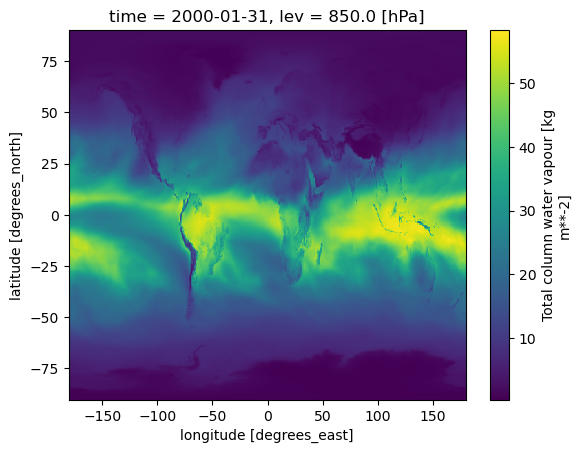

In [21]:
era_iwv_month_merragrid.isel(time=0).plot();

In [22]:
era_iwv_month_merragrid = era_iwv_month_merragrid.persist()

In [23]:
era_iwv_month_merragrid_mean = era_iwv_month_merragrid.mean(dim='time')

In [24]:
era_iwv_season_climo_merragrid = era_iwv_month_merragrid.groupby('time.season').mean()

In [26]:
%%time
era_uv_month_merragrid = regridder(era_uv_month_new, keep_attrs=True)
era_uv_month_merragrid

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 127 ms


<xarray.Dataset> Size: 599MB
Dimensions:  (time: 180, lat: 361, lon: 576)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2000-01-31 2000-02-29 ... 2014-12-31
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
    lev      float64 8B ...
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Data variables:
    u        (time, lat, lon) float64 299MB dask.array<chunksize=(50, 361, 576), meta=np.ndarray>
    v        (time, lat, lon) float64 299MB dask.array<chunksize=(50, 361, 576), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.6
    history:        2020-05-19 11:53:39 GMT by grib_to_netcdf-2.16.0: /opt/ec...
    regrid_method:  bilinear

In [27]:
era_uv_month_merragrid = era_uv_month_merragrid.persist()

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 19.04 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [28]:
era_uv_month_merragrid_mean = era_uv_month_merragrid.mean(dim='time')
era_uv_season_climo_merragrid = era_uv_month_merragrid.groupby('time.season').mean()

### Annual Differences, ERA - MERRA

In [29]:
IWV_merra_era_diff = era_iwv_month_merragrid_mean - IWV_merra_mean

In [32]:
print('IWV diffs are ', IWV_merra_era_diff.min().values, IWV_merra_era_diff.max().values)

IWV diffs are  -9.129118488312066 9.509006010726281


In [30]:
U850_merra_era_diff = era_uv_month_merragrid_mean['u'] - U850_merra_mean

In [33]:
print('U850 diffs are ', U850_merra_era_diff.min().values, U850_merra_era_diff.max().values)

U850 diffs are  -8.184469054439356 9.007597534153428


In [31]:
V850_merra_era_diff = era_uv_month_merragrid_mean['v'] - V850_merra_mean

In [34]:
print('V850 diffs are ', V850_merra_era_diff.min().values, V850_merra_era_diff.max().values)

V850 diffs are  -10.054630645501701 9.225928490636074


/glade/derecho/scratch/kdagon/tmp/ipykernel_65835/2173934773.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('seismic')


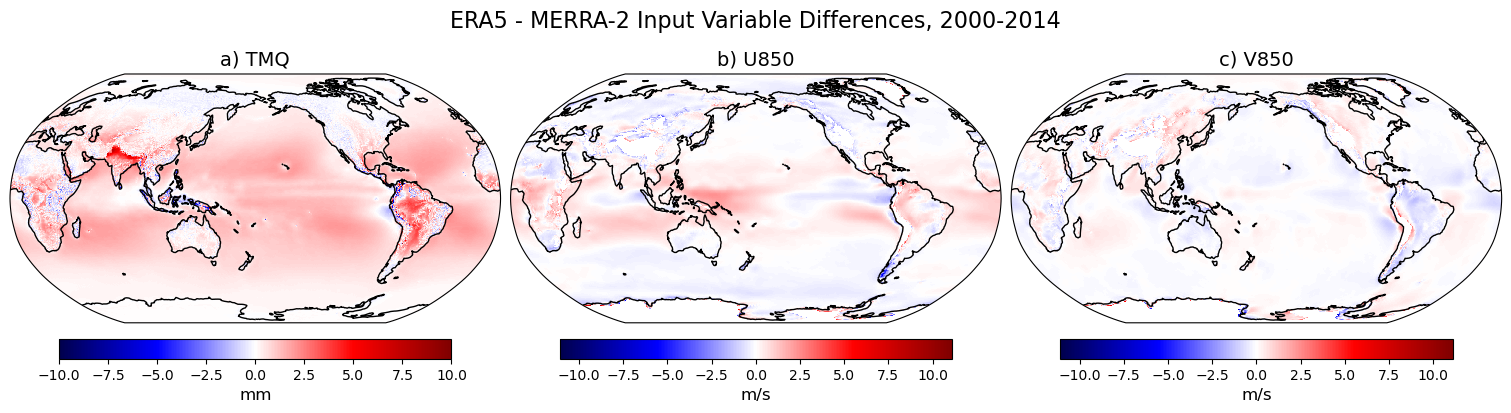

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)}, constrained_layout=True)  # 1 row, 3 columns

# define coordinates throughout
lat = IWV_merra_era_diff.lat
lon = IWV_merra_era_diff.lon

# IWV/TMQ cmap
cmap=plt.cm.get_cmap('seismic')
vmin=-10
vmax=10

# TMQ/IWV diff
pc = axes[0].pcolormesh(lon, lat, IWV_merra_era_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].set_title('a) TMQ', fontsize=14)

# winds cmap
vmin_w=-11.1
vmax_w=11.1

# U850 diff
pc_u = axes[1].pcolormesh(lon, lat, U850_merra_era_diff, cmap=cmap, vmin=vmin_w, vmax=vmax_w, transform=ccrs.PlateCarree())
axes[1].coastlines()
axes[1].set_title('b) U850', fontsize=14)

# V850 diff
pc_v = axes[2].pcolormesh(lon, lat, V850_merra_era_diff, cmap=cmap, vmin=vmin_w, vmax=vmax_w, transform=ccrs.PlateCarree())
axes[2].coastlines()
axes[2].set_title('c) V850', fontsize=14)

# add TMQ colorbar
#cbar_ax = fig.add_axes([0.2, 0.15, 0.2, 0.03]) #(left, bottom, width, height)
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar = fig.colorbar(pc, ax=axes[0], location='bottom', shrink=0.8)
cbar.ax.set_xlabel('mm', fontsize=12)

# add U850 colorbar
#cbar_ax = fig.add_axes([0.5, 0.15, 0.2, 0.03]) #(left, bottom, width, height)
#cbar = plt.colorbar(pc_u, cax=cbar_ax, orientation='horizontal')
cbar = fig.colorbar(pc_u, ax=axes[1], location='bottom', shrink=0.8)
cbar.ax.set_xlabel('m/s', fontsize=12)

# add V850 colorbar
#cbar_ax = fig.add_axes([0.5, 0.15, 0.2, 0.03]) #(left, bottom, width, height)
#cbar = plt.colorbar(pc_u, cax=cbar_ax, orientation='horizontal')
cbar = fig.colorbar(pc_v, ax=axes[2], location='bottom', shrink=0.8)
cbar.ax.set_xlabel('m/s', fontsize=12)

# add suptitle
fig.suptitle('ERA5 - MERRA-2 Input Variable Differences, 2000-2014', fontsize=16)

#plt.subplots_adjust(wspace=0.1, hspace=0.3)
#plt.tight_layout() # does not work with constrained_layout=True

#plt.savefig('../figures/toSCP/ERA-MERRA-IWV_UV850_diffs_2000-2014.png', bbox_inches='tight')

### Seasonal differences

In [43]:
lat_bounds_merra = slice(25,65)
lon_bounds_merra = slice(-180,-105)

In [37]:
IWV_merra_era_diff_season = era_iwv_season_climo_merragrid - merra_IWV_season_climo

In [46]:
IWV_merra_era_diff_season

<xarray.DataArray (season: 4, lat: 361, lon: 576)> Size: 7MB
dask.array<sub, shape=(4, 361, 576), dtype=float64, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
    lev      float64 8B 850.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'

In [47]:
print('TMQ/IWV diffs are ', IWV_merra_era_diff_season.sel(lat=lat_bounds_merra,lon=lon_bounds_merra).min().values, 
      IWV_merra_era_diff_season.sel(lat=lat_bounds_merra,lon=lon_bounds_merra).max().values)

TMQ/IWV diffs are  -3.6231952727852637 3.934519511575754


Should do the U/V diffs by variable

In [55]:
U850_merra_era_diff_season = era_uv_season_climo_merragrid['u'] - merra_U850_season_climo

In [56]:
V850_merra_era_diff_season = era_uv_season_climo_merragrid['v'] - merra_V850_season_climo

In [57]:
print('U850 diffs are ', U850_merra_era_diff_season.sel(lat=lat_bounds_merra,lon=lon_bounds_merra).min().values, 
      U850_merra_era_diff_season.sel(lat=lat_bounds_merra,lon=lon_bounds_merra).max().values)
print('V850 diffs are ', V850_merra_era_diff_season.sel(lat=lat_bounds_merra,lon=lon_bounds_merra).min().values,
      V850_merra_era_diff_season.sel(lat=lat_bounds_merra,lon=lon_bounds_merra).max().values)

U850 diffs are  -5.003106129192922 4.41101517879238
V850 diffs are  -4.640488334824231 4.884531294187706


CPU times: user 3.19 s, sys: 116 ms, total: 3.3 s
Wall time: 4.88 s


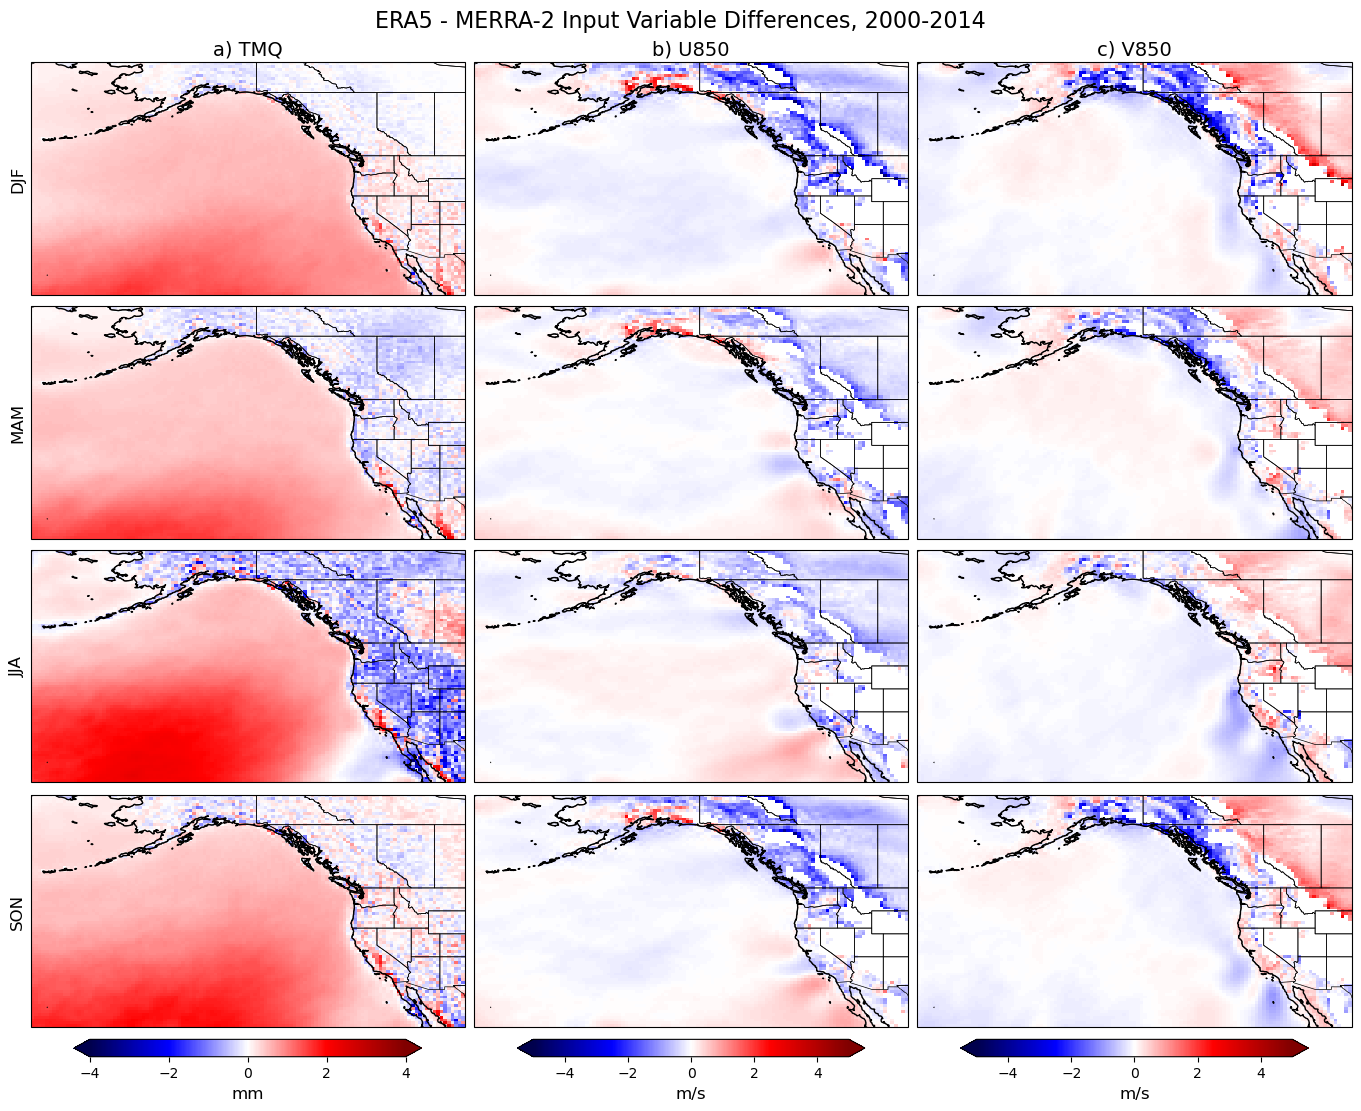

In [59]:
%%time
fig, ax = plt.subplots(4, 3, figsize=(13.5,11), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}, constrained_layout=True) # figsize is width, height

cmap = mpl.colormaps.get_cmap('seismic')

# regional subset
lat_bounds_merra = slice(25,65)
lon_bounds_merra = slice(-180,-105)

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    #print(i)
    # TMQ/IWV
    lat = IWV_merra_era_diff_season.lat.sel(lat=lat_bounds_merra)
    lon = IWV_merra_era_diff_season.lon.sel(lon=lon_bounds_merra)
    pc1 = ax[i,0].pcolormesh(lon, lat, IWV_merra_era_diff_season.sel(season=season, lat=lat_bounds_merra, lon=lon_bounds_merra), cmap=cmap, vmin=-4, vmax=4, transform=ccrs.PlateCarree())
    ax[i,0].coastlines(zorder=1)
    ax[i,0].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    ax[i,0].set_ylabel(season, fontsize=12)
    ax[i,0].set_yticks([])
    if i==0:
        ax[i,0].set_title('a) TMQ', fontsize=14)

    # U850
    pc2 = ax[i,1].pcolormesh(lon, lat, U850_merra_era_diff_season.sel(season=season, lat=lat_bounds_merra, lon=lon_bounds_merra), cmap=cmap, vmin=-5, vmax=5, transform=ccrs.PlateCarree())
    ax[i,1].coastlines(zorder=1)
    ax[i,1].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    #ax[i,1].set_yticks([])
    if i==0:
        ax[i,1].set_title('b) U850', fontsize=14)

    # V850
    pc3 = ax[i,2].pcolormesh(lon, lat,  V850_merra_era_diff_season.sel(season=season, lat=lat_bounds_merra, lon=lon_bounds_merra), cmap=cmap, vmin=-5, vmax=5, transform=ccrs.PlateCarree())
    ax[i,2].coastlines(zorder=1)
    ax[i,2].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    #ax[i,2].set_yticks([])
    if i==0:
        ax[i,2].set_title('c) V850', fontsize=14)

# add colorbar for TMQ/IWV
cbar_1 = fig.colorbar(pc1, ax=ax[3,0], location='bottom', shrink=0.8, extend='both')
cbar_1.ax.set_xlabel('mm', fontsize=12)

# add colorbar for U850
cbar_2 = fig.colorbar(pc2, ax=ax[3,1], location='bottom', shrink=0.8, extend='both')
cbar_2.ax.set_xlabel('m/s', fontsize=12);

# add colorbar for V850
cbar_3 = fig.colorbar(pc3, ax=ax[3,2], location='bottom', shrink=0.8, extend='both')
cbar_3.ax.set_xlabel('m/s', fontsize=12);

# add suptitle
fig.suptitle('ERA5 - MERRA-2 Input Variable Differences, 2000-2014', fontsize=16);

#plt.subplots_adjust(wspace=0.1) # can't use with constrained_layout

#plt.savefig('../figures/toSCP/ERA-MERRA-TMQ_UV850_diffs_2000-2014_byseason_WUS.png', bbox_inches='tight')